In [243]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pdb

It's easiest to do with TI. Assume we have uncertainties at each point.  So we will have a standard deviation in dhdl at each of $k$ lambda points. 

In [244]:
nlam = 11  # initial number of lambda
ninit = 10000  # initial number of samples
lambdas = np.linspace(0,1,nlam) # initial lambdas
stdev = np.array([0.01,0.02,0.03,0.04,0.05,0.08,0.1,0.16,0.15,0.10,0.06])  # initial uncertainties after one run
nsamples = ninit*np.ones(nlam)

If we are missing some of the data, we can just spline without it, and if we are missing edges, we set them equal to the neighbors.  That is a very rough but reasonable guess to start with, we will get better soon. 

Approximate $\sigma^2n$ as a function of $\lambda$, and fit a spline.

In [245]:
fit_var = scipy.interpolate.CubicSpline(lambdas,nsamples*(stdev**2))

In [246]:
spacings = np.linspace(0,1,50*nlam)

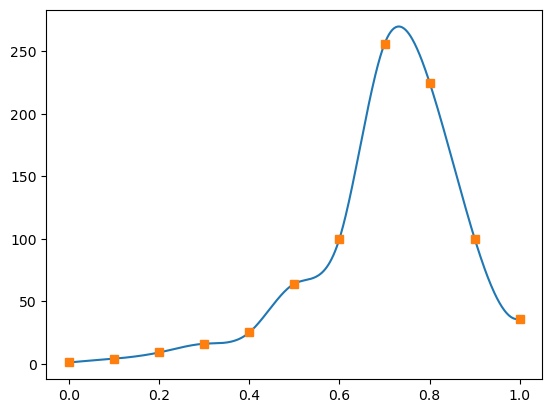

In [247]:
plt.plot(spacings,fit_var(spacings))
plt.plot(lambdas,nsamples*stdev**2,"s")
plt.show()

The total variance will be $\sum_i \frac{var(\lambda_i) w_{\lambda}^2}{n_i} $, so we want to decide the locations of the $n$ simulations that will minimize the total variance. 

Figuring out $w_{\lambda}$ is a little hard when we have uneven spacings, we'll just do it as the difference between consecutive lambdas, $\lambda_{i+1} - \lambda_i$, averaged at each $i$.

In [262]:
def expected_variance(nsamps,lambdas,varfunc,components=False):
    pdb.set_trace()
    nonzero_locs = (nsamps!=0)
    dlambda = np.diff(lambdas[nonzero_locs])
    wlambda = np.zeros(len(dlambda)+1)
    wlambda[1:] += dlambda
    wlambda[:-1] += dlambda
    wlambda *= 0.5
    #print(wlambda,np.sum(wlambda))
    #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
    vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
    vsum = np.sum(vals)
    if components==False:
        return vsum
    else:
        return vsum,vals

If we just had to run one simulation, this would be easy, as we find the location that minizes the variance.  But we need to iteratively find where to put them.

In [253]:
# initially we have ninit points at all locations.
ntotal = 101
lamall = np.linspace(0,1,ntotal)
nall = np.zeros([ntotal])
for i in range(ntotal):
    if (i%10 == 0):
        nall[i] = ninit

In [260]:
import pdb

In [263]:
#contribution to the uncertainty at each point 

total,vals = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var,components=True)
plt.plot(lamall[nall!=0],vals)
plt.show()

> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(3)expected_variance()
      1 def expected_variance(nsamps,lambdas,varfunc,components=False):
      2     pdb.set_trace()
----> 3     nonzero_locs = (nsamps!=0)
      4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(4)expected_variance()
      2     pdb.set_trace()
      3     nonzero_locs = (nsamps!=0)
----> 4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(5)expected_variance()
      3     nonzero_locs = (nsamps!=0)
      4     dlambda = np.diff(lambdas[nonzero_locs])
----> 5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(6)expected_variance()
      4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)
----> 6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda
      8     wlambda *= 0.5



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(7)expected_variance()
      5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda
----> 7     wlambda[:-1] += dlambda
      8     wlambda *= 0.5
      9     #print(wlambda,np.sum(wlambda))



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(8)expected_variance()
      6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda
----> 8     wlambda *= 0.5
      9     #print(wlambda,np.sum(wlambda))
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(11)expected_variance()
      9     #print(wlambda,np.sum(wlambda))
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
---> 11     vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
     12     vsum = np.sum(vals)
     13     if components==False:



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(12)expected_variance()
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
     11     vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
---> 12     vsum = np.sum(vals)
     13     if components==False:
     14         return vsum



ipdb>  p vals


array([2.50000000e-07, 4.00000000e-06, 9.00000000e-06, 1.60000000e-05,
       1.40625000e-05, 1.14633092e-05, 1.60000000e-05, 1.74898158e-05,
       2.50000000e-05, 2.89495536e-05, 1.44780179e-05, 1.60000000e-05,
       1.07955312e-05, 1.07622143e-05, 2.28446016e-05, 2.75625000e-05,
       2.81981257e-05, 1.11959229e-05, 1.80000000e-05, 9.00000000e-06])


ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(13)expected_variance()
     11     vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
     12     vsum = np.sum(vals)
---> 13     if components==False:
     14         return vsum
     15     else:



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(16)expected_variance()
     12     vsum = np.sum(vals)
     13     if components==False:
     14         return vsum
     15     else:
---> 16         return vsum,vals



ipdb>  n


--Return--
(0.00031105209209821434, array([2.5000...00000000e-06]))
> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(16)expected_variance()
     12     vsum = np.sum(vals)
     13     if components==False:
     14         return vsum
     15     else:
---> 16         return vsum,vals



ipdb>  n


--Return--
None
> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/4210526497.py(3)<module>()
      1 #contribution to the uncertainty at each point
      2 
----> 3 total,vals = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var,components=True)
      4 plt.plot(lamall[nall!=0],vals)
      5 plt.show()



ipdb>  n


    [... skipped 1 hidden frame]

> /opt/anaconda3/envs/python_class/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3580)run_code()
   3578             finally:
   3579                 # Reset our crash handler in place
-> 3580                 sys.excepthook = old_excepthook
   3581         except SystemExit as e:
   3582             if result is not None:



ipdb>  q


Now iteratively add points:

In [ ]:
numruns = 10
runlocs = np.zeros(numruns)
runmins = np.zeros(numruns)
for i in range(numruns):
    expect_current = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var)
    min_i = 0
    min_trial = expect_current
    for j in range(ntotal):
        ntrial = nall.copy()
        ntrial[j] += ninit
        # if we add more samples here, how much does it improve the uncertainty
        expect_trial = expected_variance(nsamps=ntrial,lambdas=lamall, varfunc=fit_var)
        #print(i,j,expect_trial)
        if expect_trial < min_trial:   # OK, this currently the lowest point
            min_j = j
            min_trial = expect_trial
    # OK we have found the location the minimizes the next place. Change nall
    nall[min_j] += ninit
    runlocs[i] = min_j
    runmins[i] = min_trial

> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(3)expected_variance()
      1 def expected_variance(nsamps,lambdas,varfunc,components=False):
      2     pdb.set_trace()
----> 3     nonzero_locs = (nsamps!=0)
      4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(4)expected_variance()
      2     pdb.set_trace()
      3     nonzero_locs = (nsamps!=0)
----> 4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(5)expected_variance()
      3     nonzero_locs = (nsamps!=0)
      4     dlambda = np.diff(lambdas[nonzero_locs])
----> 5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(6)expected_variance()
      4     dlambda = np.diff(lambdas[nonzero_locs])
      5     wlambda = np.zeros(len(dlambda)+1)
----> 6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda
      8     wlambda *= 0.5



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(7)expected_variance()
      5     wlambda = np.zeros(len(dlambda)+1)
      6     wlambda[1:] += dlambda
----> 7     wlambda[:-1] += dlambda
      8     wlambda *= 0.5
      9     #print(wlambda,np.sum(wlambda))



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(8)expected_variance()
      6     wlambda[1:] += dlambda
      7     wlambda[:-1] += dlambda
----> 8     wlambda *= 0.5
      9     #print(wlambda,np.sum(wlambda))
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(11)expected_variance()
      9     #print(wlambda,np.sum(wlambda))
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
---> 11     vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
     12     vsum = np.sum(vals)
     13     if components==False:



ipdb>  n


> /var/folders/4v/g0zjp6c95535931grpmdq5840000gp/T/ipykernel_18969/2817245518.py(12)expected_variance()
     10     #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
     11     vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
---> 12     vsum = np.sum(vals)
     13     if components==False:
     14         return vsum



ipdb>  p vals


array([2.50000000e-07, 4.00000000e-06, 9.00000000e-06, 1.60000000e-05,
       1.40625000e-05, 1.14633092e-05, 1.60000000e-05, 1.74898158e-05,
       2.50000000e-05, 2.89495536e-05, 1.44780179e-05, 1.60000000e-05,
       1.07955312e-05, 1.07622143e-05, 2.28446016e-05, 2.75625000e-05,
       2.81981257e-05, 1.11959229e-05, 1.80000000e-05, 9.00000000e-06])


New locations:

In [258]:
fit_var(nsamps=ntrial,lambdas=lamall

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ensure_c_contiguous',
 '_evaluate',
 '_get_dtype',
 '_validate_bc',
 'antiderivative',
 'axis',
 'c',
 'construct_fast',
 'derivative',
 'extend',
 'extrapolate',
 'from_bernstein_basis',
 'from_spline',
 'integrate',
 'roots',
 'solve',
 'x']

In [256]:
runlocs

array([74., 84., 65., 55., 77., 88., 68., 45., 73., 90.])

What the variance decreases to after each addition:

In [28]:
runmins

array([0.00066395, 0.00058426, 0.00051215, 0.00047039, 0.00043024,
       0.00039757, 0.00036697, 0.00034749, 0.00032905, 0.00031105])

Where the new data gets put:

In [29]:
nall

array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0., 10000.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
       10000.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
           0.,     0., 10000.,     0.,     0.,     0.,     0., 10000.,
           0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
           0., 10000.,     0.,     0., 10000.,     0., 10000.,     0.,
           0., 10000., 10000.,     0.,     0., 10000.,     0.,     0.,
       10000.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
       10000.,     0., 20000.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0., 10000.])

New variance

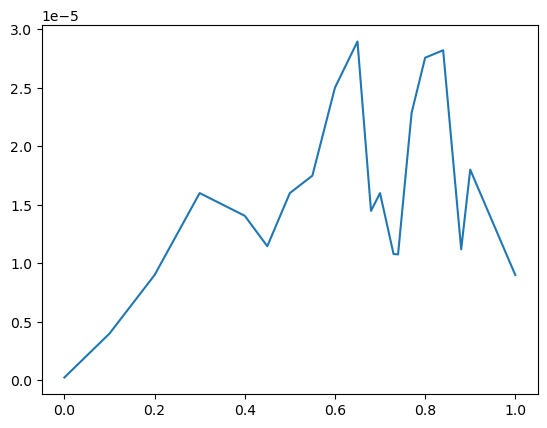

In [30]:
#contribution to the uncertainty at each point after adding data.
total,vals = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var,components=True)
plt.plot(lamall[nall!=0],vals)
plt.show()

OK, now let's take a look if we just have uncertainties for the $\Delta G$. I think we have to just back-calculate the uncertainty at each $\lambda$, starting from the equations in alchemlyb.

The uncertainties to use as inputs here are the off-diagonal elements in `ti.d_delta_f_` (i.e. the ones that are one diagonal up or down the main diagonal - the entries are equal.  These are the results from the sample data.

In [155]:
derrors_ti = np.array([0.066711, 0.053982, 0.067663, 0.106295, 0.1195130, 0.126304, 0.329933, 0.468135, 0.367503, 0.134171])

Then we need to solve for the uncertainties at each point. 

These are the uncertainties between states for MBAR, though they are not really the same.  They should be roughly similar, so I'm actually not sure why they are so different.  Perhaps not enough data?   I'm extractin them as 
`mbar.d_delta_f_[0.0][0,1]`,`mbar.d_delta_f_[0.1][0.2]`, etc.

In [189]:
derrors_mbar = np.array([0.229604, 0.185374, 0.156106, 0.3097456, 0.293402, 0.407582, 0.292766, 0.299239, 0.135209, 0.055202])

In [201]:
derrors = derrors_mbar

In [202]:
nlam = 11
lambdas = np.linspace(0,1,nlam) # initial lambdas
dlambda = np.diff(lambdas)
dlambda *= 0.5
dlambda = dlambda**2

In [242]:
A = np.zeros([nlam,nlam])
B = np.zeros([nlam])
B[:-1] = derrors**2
for i in range(nlam-1):
    for j in range(np.max([0,i]),np.min([i+2,nlam])):
        A[i,j] = dlambda[j-1]
A[nlam-1,0] = 1 
# this is a kludge, just saying that over the first two points, the variance is equal
B[-1] = (derrors[0]**2)/(2*dlambda[0])
print(np.linalg.solve(A,B))
#new_stdev = np.sqrt(np.linalg.solve(A,B))
print(A)
print(B)

[ 10.54359936  10.54359936   3.20180859   6.54582471  31.83110998
   2.60278346  63.84645123 -29.56167893  65.37927057 -58.0666811
  59.28558542]
[[0.0025 0.0025 0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.0025 0.0025 0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.0025 0.0025 0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.0025 0.0025 0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.0025 0.0025 0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.0025 0.0025 0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.0025 0.0025 0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0025 0.0025 0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0025 0.0025
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0025
  0.0025]
 [1.     0.     0.     0.     0.     0.     0.     0.     0.     0

In [197]:
print(new_stdev)

[0.94343601 0.94343601 0.52492954 1.24730173 1.72153687 1.65820797
 1.90563021 6.31750641 6.91008423 2.50481896 0.96261357]


In [239]:
errs = np.linspace(-50,10,10000)

In [240]:
mins = np.zeros(10000)
for i,e in enumerate(errs):
    B[-1] = e
    mins[i] = np.min(np.linalg.solve(A,B))

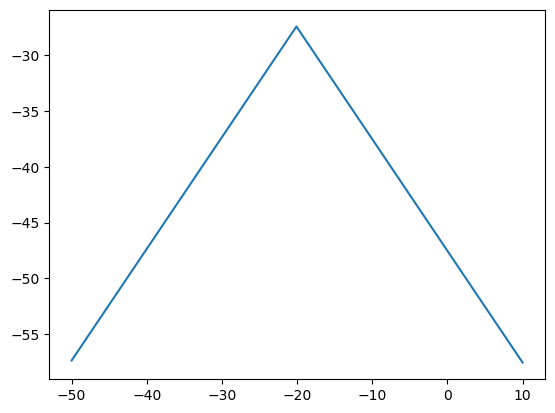

In [241]:
plt.plot(errs,mins)